In [1]:
import os, time, h5py, platform, json, sys
if platform.system() == 'Linux':
    import matplotlib
    matplotlib.use('Agg')
sys.path.append("/Users/gkoolstra/Documents/Code")
sys.path.append(r"C:\Users\Gerwin\Documents\Code")
from matplotlib import pyplot as plt
from shutil import copyfile
import numpy as np
from tqdm import tqdm, trange
from scipy.optimize import minimize
from scipy.signal import savgol_filter
from termcolor import cprint
from glob import glob
from Common import common, kfit
import matplotlib.gridspec as gridspec
from TrapAnalysis import trap_analysis, artificial_anneal as anneal
%matplotlib inline
%config InlineBackend.figure_format='retina'

try:
    sys.path.append(r"S:\_Data\170422 - EonHe M018V6 with L3 etch\experiment")
    from data_cache import dataCacheProxy
except:
    pass

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Solve for the position of $N$ particles in the trap

To give some control over the input of the simulation, the block of code below lets you fix an initial condition for the electron positions. To fix the x-coordinate use `init_trap_x`, and y-coordinate `init_trap_y`. Leaving these values to `None` will use the standard initial condition.

In practice, `init_trap_x=None` is reliable for `N_e = 1` or `N_e = 2`. For higher `N_e` there is a larger probability to get stuck in a local minimum, which can be avoided when specifying the initial condition if you roughly know what the final configuration should look like.

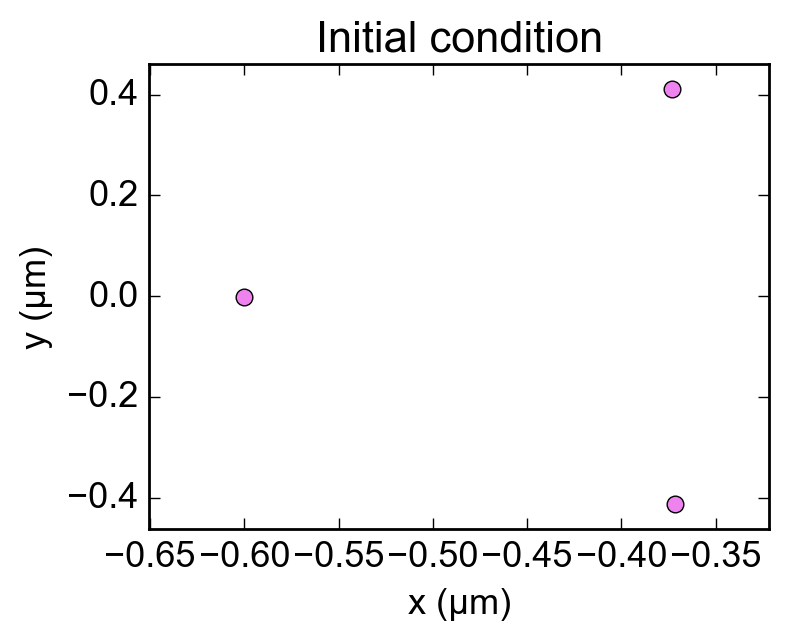

In [3]:
# If you don't want to change the initial conditions.
init_trap_x = None
init_trap_y = None
use_adaptive_initial_guess = 0

N_e = 3

if N_e == 1:
    # For N_e = 1
    init_trap_x = np.array([-0.5E-6])
    init_trap_y = np.array([0.0])
    use_adaptive_initial_guess = 0
elif N_e == 2:
    use_adaptive_initial_guess = 1
elif N_e == 3:
    # Two different configurations for N_e = 3
    init_trap_x = np.array([-6.00456135e-07,  -3.72871079e-07,  -3.71413101e-07])
    init_trap_y = np.array([-1.96660595e-09,   4.10925567e-07,  -4.11744352e-07])
    use_adaptive_initial_guess = 1
#     init_trap_x = np.array([-3.28382194e-07, -5.74209246e-07, -5.75483173e-07])
#     init_trap_y = np.array([ 0, 3.35430418e-07, -3.34591166e-07])
#     use_adaptive_initial_guess = 0
    
elif N_e == 4:
#     Two different configurations for N_e = 4
    init_trap_x = np.array([-3.25968284e-07,  -3.23481408e-07,  -6.55414803e-07, -6.55475553e-07])
    init_trap_y = np.array([-4.48483517e-07,   4.47725447e-07,   2.31437204e-07, -2.26984585e-07])
    use_adaptive_initial_guess = 1

    # init_trap_x = np.array([-1.81749932e-07,  -5.23149719e-07,  -8.89385208e-07, -5.47296425e-07])
    # init_trap_y = np.array([-1.53252092e-08,   2.40237998e-07,   7.55036140e-09, -2.35563263e-07])

if init_trap_x is not None:
    min_x = np.min(init_trap_x)*1E6-0.05
    max_x = np.max(init_trap_x)*1E6+0.05
    min_y = np.min(init_trap_y)*1E6-0.05
    max_y = np.max(init_trap_y)*1E6+0.05

    fig = plt.figure(figsize=(4.,3.))
    common.configure_axes(13)
    plt.plot(init_trap_x * 1E6, init_trap_y * 1E6, 'o', color='violet')
    plt.xlabel("x (%sm)"%(chr(956)))
    plt.ylabel("y (%sm)"%(chr(956)))
    plt.title("Initial condition")

    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)

With the initial condition set up (or left blank, see above), the electron positions as a function of voltage can be determined. Below we first define the voltage points and then let the solver do its job. 

The solver also returns the energy of the minimized energy configurations, so that you can check whether there are any jumps that can point to a local minimum.

Sweeping resonator from 0.60 V to 0.60 V


11it [01:30,  8.19s/it]


Number of unbounded electrons = 0


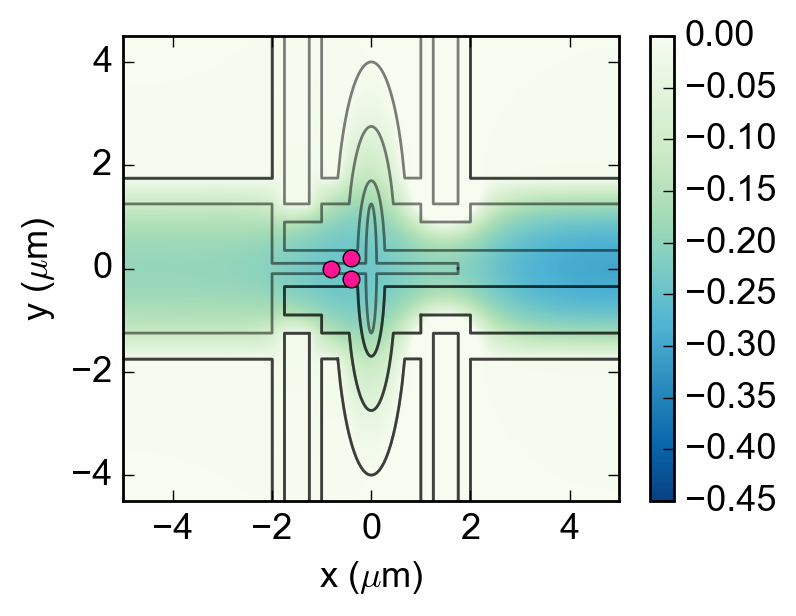

In [4]:
from TrapAnalysis.solve_eom import FullSolver

settings_file = r"/Users/gkoolstra/Desktop"
settings_file += r"/With L3 etch - just trap/settings.json"
fs = FullSolver(settings_file)

# Set up the RF electric field path and load it into memory
fs.resonator_constants['f0'] = 6.405E9
fs.resonator_constants['Q'] = 1.3E4
fs.resonator_constants['Z0'] = 90.0
fs.set_rf_interpolator()

Vtrap = np.linspace(0.15, 0.35, 11)
Vrg = np.linspace(-0.415, -0.426, len(Vtrap))
Vres = 0.60 * np.ones(len(Vtrap)) 
Vtg = 0.00 * np.ones(len(Vtrap))
Vcg = None

electron_positions, electron_energies, EVecs, EVals = fs.get_trap_electron_positions(Vres, Vtrap, Vrg, Vtg, N=N_e, 
                                                                                     initial_guess_x=init_trap_x, 
                                                                                     initial_guess_y=init_trap_y, 
                                                                                     use_adaptive_initial_guess=use_adaptive_initial_guess, 
                                                                                     solve_equations_of_motion=1)
tex = electron_positions[:, ::2]
tey = electron_positions[:, 1::2]

## Verify that EOM matrices $\mathcal{K}$ and $\mathcal{M}$ are symmetric

Note that their product $\mathcal{M}^{-1} \mathcal{K}$ does not have to be symmetric.

In [15]:
K, M = fs.setup_eom(electron_positions[-1, :])

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


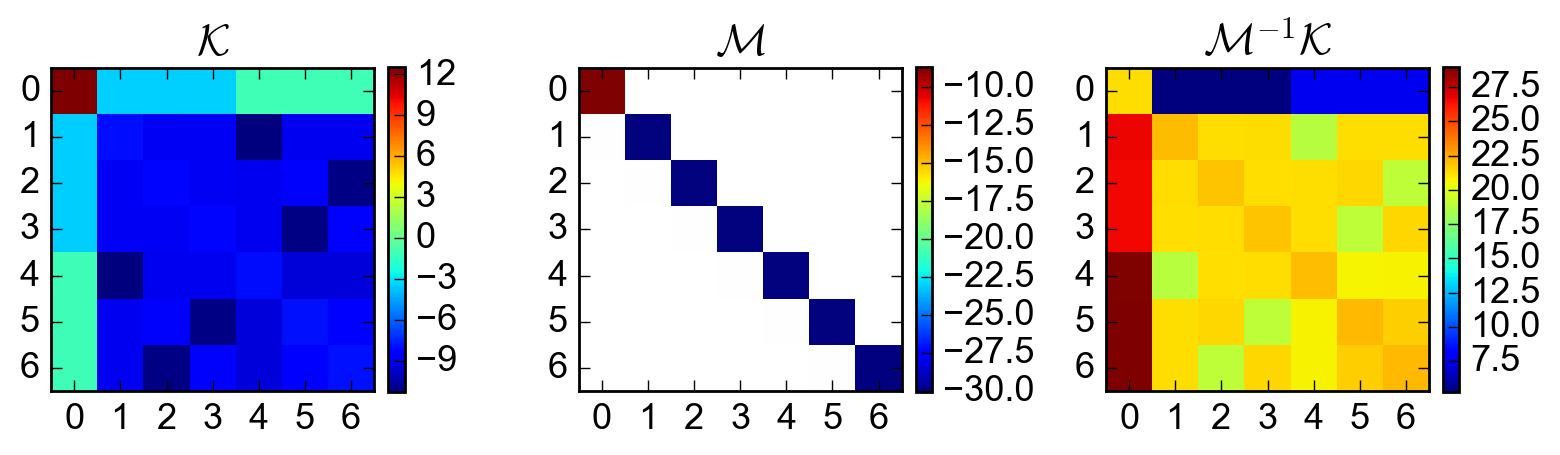

In [22]:
fig = plt.figure(figsize=(8.,3.))
common.configure_axes(13)
plt.subplot(131)
im = plt.imshow(np.log10(np.abs(K)), interpolation='none', origin='upper')
plt.title("$\mathcal{K}$")
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.subplot(132)
im = plt.imshow(np.log10(np.abs(M)), interpolation='none', origin='upper')
plt.title("$\mathcal{M}$")
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.subplot(133)
im = plt.imshow(np.log10(np.abs(np.dot(np.linalg.inv(M), K))), interpolation='none', origin='upper')
plt.title("$\mathcal{M}^{-1} \mathcal{K}$")
plt.colorbar(im, fraction=0.046, pad=0.04)

fig.tight_layout()

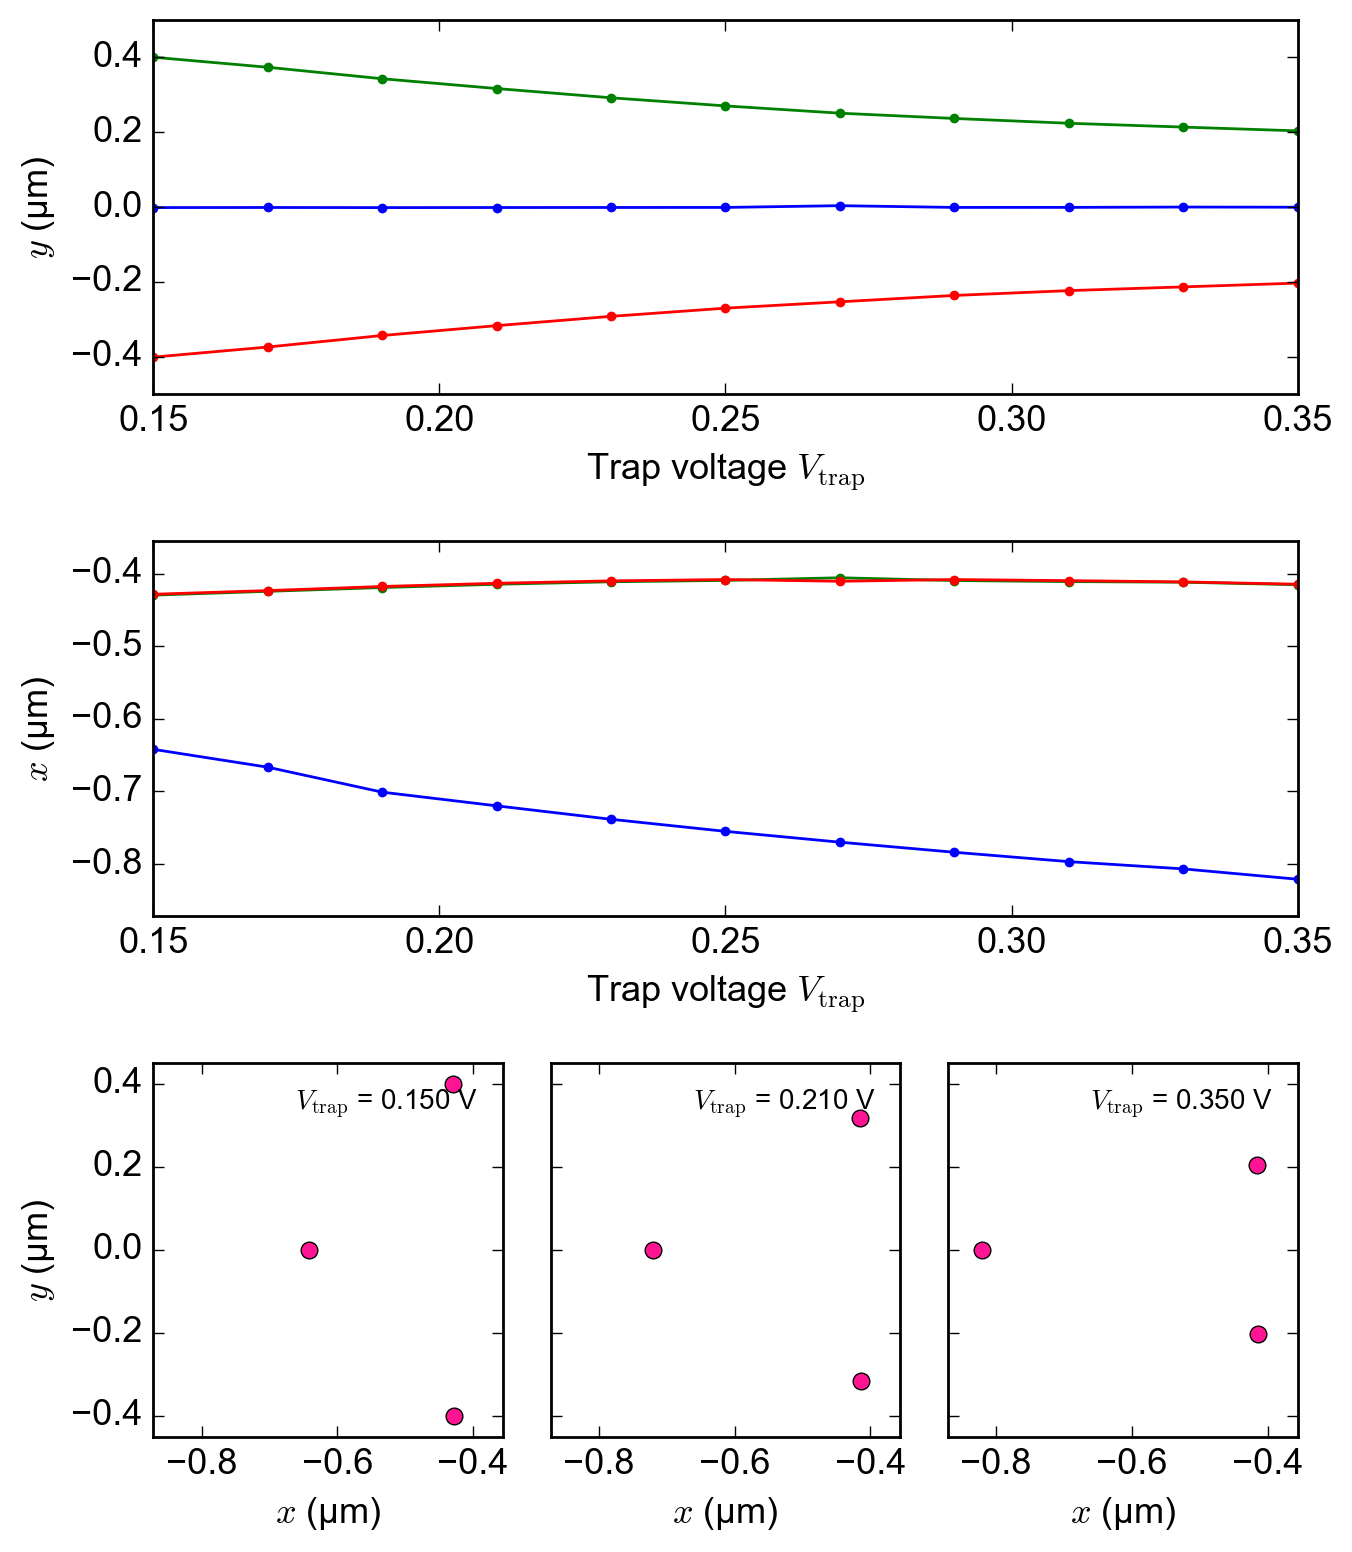

In [5]:
fig = plt.figure(figsize=(7.,8.))
common.configure_axes(13)
gs = gridspec.GridSpec(3, 3)

ax0 = plt.subplot(gs[0, :])
ax1 = plt.subplot(gs[1, :])
ax2 = plt.subplot(gs[2, 0])
ax3 = plt.subplot(gs[2, 1])
ax4 = plt.subplot(gs[2, 2])

tex_hat = np.zeros(np.shape(tex))
tey_hat = np.zeros(np.shape(tey))

for i in range(N_e):
    ax0.plot(Vtrap, tey[:,i] * 1E6, '.-')
    
    tey_hat[:, i] = savgol_filter(tey[:,i], 5, 3) # window length, polynomial order
#     ax0.plot(Vtrap, tey_hat[:, i] * 1E6, '-', color='r')
    
ax0.set_xlabel("Trap voltage $V_\mathrm{trap}$")
ax0.set_ylabel("$y$ (%sm)"%(chr(956)))
ax0.set_xlim(np.min(Vtrap), np.max(Vtrap))

for i in range(N_e):
    ax1.plot(Vtrap, tex[:,i] * 1E6, '.-')
    
    tex_hat[:, i] = savgol_filter(tex[:,i], 5, 3) # window length, polynomial order
#     ax1.plot(Vtrap, tex_hat[:, i] * 1E6, '-', color='r')
    
ax1.set_xlabel("Trap voltage $V_\mathrm{trap}$")
ax1.set_ylabel("$x$ (%sm)"%(chr(956)))
ax1.set_xlim(np.min(Vtrap), np.max(Vtrap))

points = [0.150, 0.21, 0.35]
min_x = np.min(tex)*1E6-0.05
max_x = np.max(tex)*1E6+0.05
min_y = np.min(tey)*1E6-0.05
max_y = np.max(tey)*1E6+0.05

ax1.set_ylim(min_x, max_x)

for n, p in enumerate(points):
    idx = common.find_nearest(Vtrap, p)
    vars()['ax%d'%(n+2)].plot(tex[idx, :] * 1E6, tey[idx, :] * 1E6, 'o', color='deeppink', 
                              label="$V_\mathrm{trap}$ = %.3f V"%(p))
    vars()['ax%d'%(n+2)].set_xlim(min_x, max_x)
    vars()['ax%d'%(n+2)].set_ylim(min_y, max_y)
    vars()['ax%d'%(n+2)].locator_params(axis='x', nbins=4)
    vars()['ax%d'%(n+2)].legend(loc=1, frameon=False, markerscale=0, prop={"size" : 10})
    
    vars()['ax%d'%(n+2)].set_xlabel("$x$ (%sm)"%(chr(956)))
    if n > 0: 
        vars()['ax%d'%(n+2)].set_yticklabels([])
    else:
        vars()['ax%d'%(n+2)].set_ylabel("$y$ (%sm)"%(chr(956)))
    
fig.tight_layout()

The figure above shows the electron position along the channel ($x$) and across the channel ($y$) as function of the voltage as well as three snap shots at the points that can be defined in the code block above.

(0.14999999999999999, 0.34999999999999998)

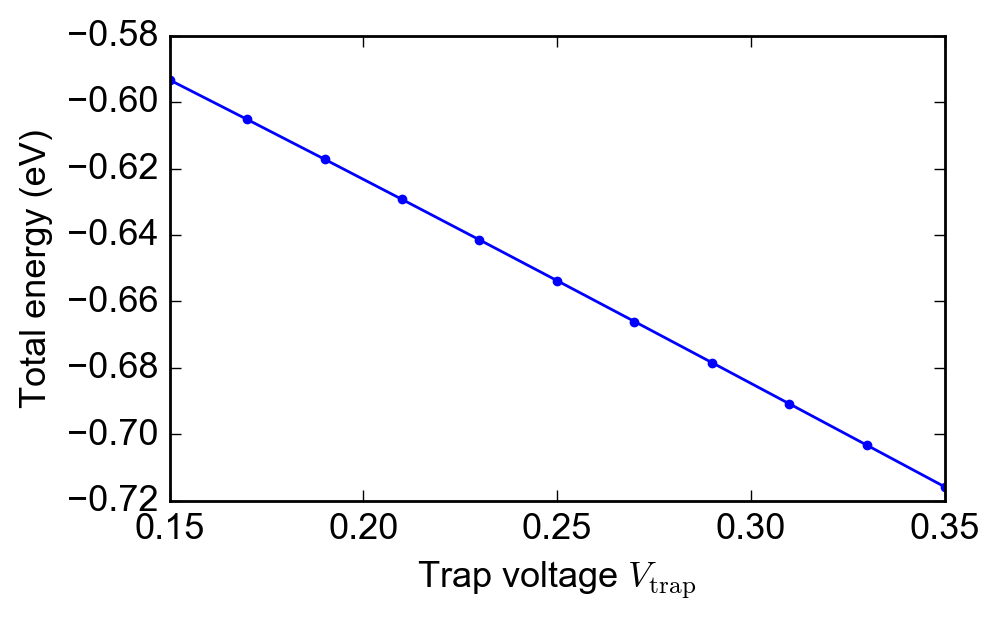

In [6]:
plt.figure(figsize=(5.,3.))
plt.plot(Vtrap, electron_energies, '.-')
plt.xlabel("Trap voltage $V_\mathrm{trap}$")
plt.ylabel("Total energy (eV)")
plt.xlim(np.min(Vtrap), np.max(Vtrap))

In [13]:
inspect_idx = common.find_nearest(Vtrap, 0.350)
electrons_x = np.mean(tex[inspect_idx, :]) * 1E6
electrons_y = np.mean(tey[inspect_idx, :]) * 1E6

xev = np.linspace(np.min(tex[inspect_idx, :])*1E6 - 0.025, 
                  np.max(tex[inspect_idx, :])*1E6 + 0.025, 2000)
yev = np.linspace(np.min(tey[inspect_idx, :])*1E6 - 0.05, 
                  np.max(tey[inspect_idx, :])*1E6 + 0.05, 2000)

fs.set_dc_interpolator(Vres[inspect_idx], Vtrap[inspect_idx], Vrg[inspect_idx], Vtg[inspect_idx])

<IPython.core.display.Javascript object>


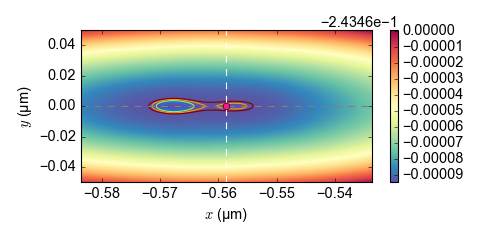

<IPython.core.display.Javascript object>


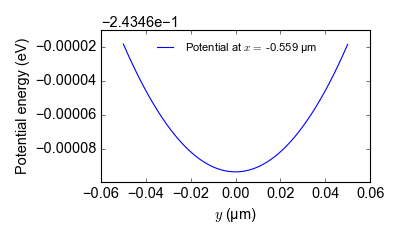

In [14]:
# %matplotlib notebook
# %matplotlib notebook
# from matplotlib import pyplot as plt

potential = fs.dc_interpolator(xev * 1E-6, yev * 1E-6).T

fig = plt.figure(figsize=(6.,3.))
common.configure_axes(13)
plt.contour(xev, yev, potential, levels=[np.min(potential) + k * 2E-7 for k in range(5)], color='k', lw=1)
plt.pcolormesh(xev, yev, potential, cmap=plt.cm.Spectral_r)
plt.plot(tex[inspect_idx, :]*1E6, tey[inspect_idx, :]*1E6, 'o', color='deeppink')
plt.colorbar()
plt.vlines(np.mean(tex[inspect_idx, :]) * 1E6, np.min(yev), np.max(yev), linestyles='--', color='white')
plt.hlines(0, np.min(xev), np.max(xev), linestyles='--', color='gray')

plt.xlim(np.min(xev), np.max(xev))
plt.ylim(np.min(yev), np.max(yev))
plt.xlabel("$x$ (%sm)"%(chr(956)))
plt.ylabel("$y$ (%sm)"%(chr(956)))
fig.tight_layout()

fig = plt.figure(figsize=(5.,3.))
common.configure_axes(13)
plt.plot(yev, fs.dc_interpolator(np.mean(tex[inspect_idx, :]), yev*1E-6).T, 
         label="Potential at $x =$ %.3f %sm"%(np.mean(tex[inspect_idx, :]) * 1E6, chr(956)))
# plt.plot(tey[inspect_idx, :] * 1E6, fs.dc_interpolator(np.mean(tex[inspect_idx, :]), tey[inspect_idx, :]).flatten(), 
#          'o', color='deeppink', label="Electron positions")
plt.xlabel("$y$ (%sm)"%(chr(956)))
plt.ylabel("Potential energy (eV)")
plt.legend(loc=0, prop={"size" : 10}, frameon=False)
fig.tight_layout()

Here is an opportunity to save the electron positions, since this step can take a while you may want to run this only once and then play with the trap solver separately by loading the positions from a file.

In [91]:
# savepath = r"/Users/gkoolstra/Desktop/1, 2, 3, 4 Model"
savepath = r"/Volumes/slab/Gerwin/Electron on helium/Papers/2017 - Circuit QED with a single electron on helium/Figure 3"

if 0:
    h5_filename = os.path.join(savepath, 'position_data_%d_electrons.h5' % N_e )

    if os.path.exists(h5_filename):
        os.remove(h5_filename)

    print("%s ..."%h5_filename)
    with h5py.File(h5_filename, 'w') as myfile:
        myfile.create_dataset("Vres",  data=Vres)
        myfile.create_dataset("Vtrap",  data=Vtrap)
        myfile.create_dataset("Vrg",  data=Vrg)
        myfile.create_dataset("Vtg",  data=Vtg)
        
        myfile.create_dataset("xi",  data=tex)
        myfile.create_dataset("yi",  data=tey)
        
        myfile.create_dataset("EVecs",  data=EVecs)
        myfile.create_dataset("EVals",  data=EVecs)

# Solve the equations of motion using `TrapSolver`

To solve the equations of motion we have to initialize the FEM data at the start of the voltage sweeps

In [7]:
all_ordered_freqs = list()

use_filtered_positions = False
if use_filtered_positions: 
    el_x, el_y = tex_hat, tey_hat
else:
    el_x, el_y = tex, tey

for k in trange(np.shape(EVecs)[0]):
    cavity_contributions = EVecs[k, 0, :]
    largest_cavity_contributions = np.argsort(np.abs(cavity_contributions))[::-1]
    all_ordered_freqs.append(np.sqrt(EVals[k, largest_cavity_contributions])/(2*np.pi*1E9))
    
all_ordered_freqs=np.array(all_ordered_freqs)

100%|██████████| 11/11 [00:00<00:00, 31796.93it/s]


From our estimate of the zero-point voltage on the resonator $V_\mathrm{zpf} = \omega_0 \sqrt{\hbar Z / 2}$ and the zero point motion of the electron $x_\mathrm{zpf} = \sqrt{\hbar / 2 m_e \omega}$, you can calculate that the coupling strength of a single electron should be given by
$$
g / 2\pi = \frac{1}{2} e E_0 f_0 \sqrt{\frac{Z}{m_e \omega_e}}
$$

Below we define this function and calculate the coupling as function of the trap voltage.
Note that there is a dependency on the trap voltage, since the trap voltage affects $\omega_e$. Additionally there is a slight dependence of $E_0$ on $V_\mathrm{trap}$, since $E_0$ is position dependent, and the electron positions are $V_\mathrm{trap}$ dependent. Note that if there are multiple electrons (if `N_e > 1`), the value of $E_0$ averaged over the electron positions is taken.

{'P': -100, 'Z0': 90, 'f0': 6405000000.0, 'e': 1.602e-19, 'Q': 13000.0, 'm_e': 9.11e-31, 'eps0': 8.85e-12}


(0.14999999999999999, 0.34999999999999998)

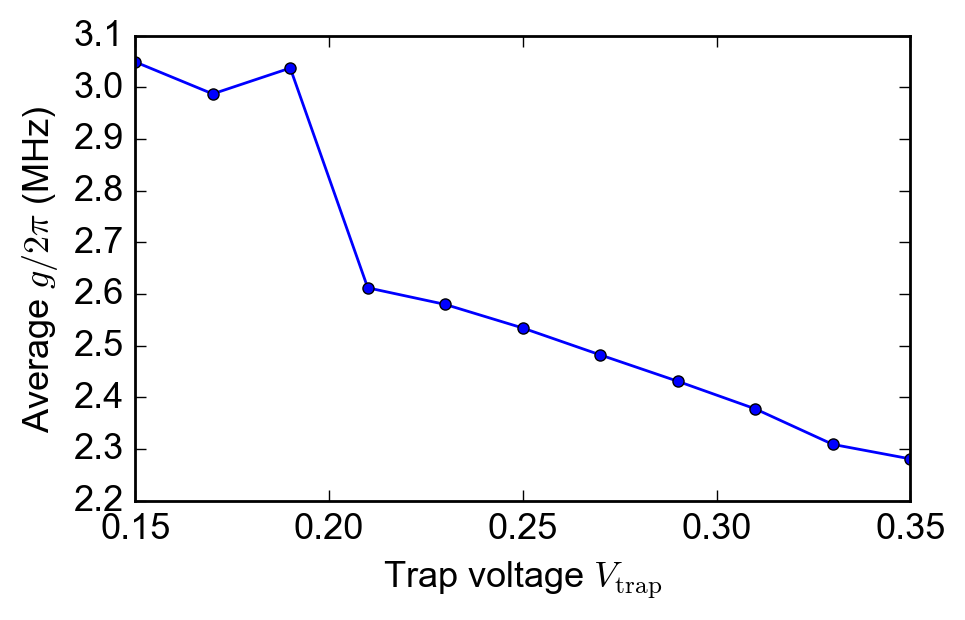

In [8]:
from TrapAnalysis.resonator_analysis import get_resonator_constants
from TrapAnalysis.trap_analysis import get_constants
constants = get_resonator_constants().copy()
constants.update(get_constants())

constants['f0'] = 6.405E9
constants['Z0'] = 90
constants['Q'] = 1.3E4
print(constants)

def get_coupling(E0, fe):
    """
    E0 is the electric field in the y-direction when +-0.5 V is applied to the left and right pin of the 
    resonator, respectively. This _must_ be the differential mode of the resonator.
    """
    return constants['e'] * E0/2. * constants['f0'] * np.sqrt(constants['Z0']/(constants['m_e'] * 2*np.pi*fe))

couplings = list()
jj = 0
for texs, teys in zip(el_x, el_y):
    fe = all_ordered_freqs[jj, 1] * 1E9
    couplings.append(get_coupling(fs.Ey(texs, teys), fe))
    jj += 1
    
couplings = np.mean(np.array(couplings), axis=1)

plt.figure(figsize=(5.,3.))
common.configure_axes(13)
plt.plot(Vtrap, np.abs(couplings)/1E6, '-o', ms=4)
plt.ylabel("Average $g / 2\pi$ (MHz)")
plt.xlabel("Trap voltage $V_\mathrm{trap}$")
plt.xlim(np.min(Vtrap), np.max(Vtrap))

Let's also load the measured traces to compare it with the simulated cavity response.

In [9]:
datapath = r"/Volumes/slab/Gerwin/Electron on helium/Papers/2017 - Circuit QED with a single electron on helium/Figure 3"
filename = r"exported_traces_mag_n_phase.h5"

with h5py.File(os.path.join(datapath, filename), 'r') as hf:
    Vtrap_experiment = hf['Vtrap'][:]
    Vrg_experiment = hf['Vrg'][:]
    
    mags_experiment_0 = hf['mags_averaged_normalized_Ne_0'][:]
    mags_experiment_1 = hf['mags_averaged_normalized_Ne_1'][:]
    mags_experiment_2 = hf['mags_averaged_normalized_Ne_2'][:]
    mags_experiment_3 = hf['mags_averaged_normalized_Ne_3'][:]
    mags_experiment_4 = hf['mags_averaged_normalized_Ne_4'][:]
    
    phases_experiment_0 = hf['phase_averaged_Ne_0'][:]
    phases_experiment_1 = hf['phase_averaged_Ne_1'][:]
    phases_experiment_2 = hf['phase_averaged_Ne_2'][:]
    phases_experiment_3 = hf['phase_averaged_Ne_3'][:]
    phases_experiment_4 = hf['phase_averaged_Ne_4'][:]

In [10]:
colors = [plt.cm.viridis(frac) for frac in [0.2, 0.4, 0.6, 0.8, 1.0]]
color = colors[4 - N_e]

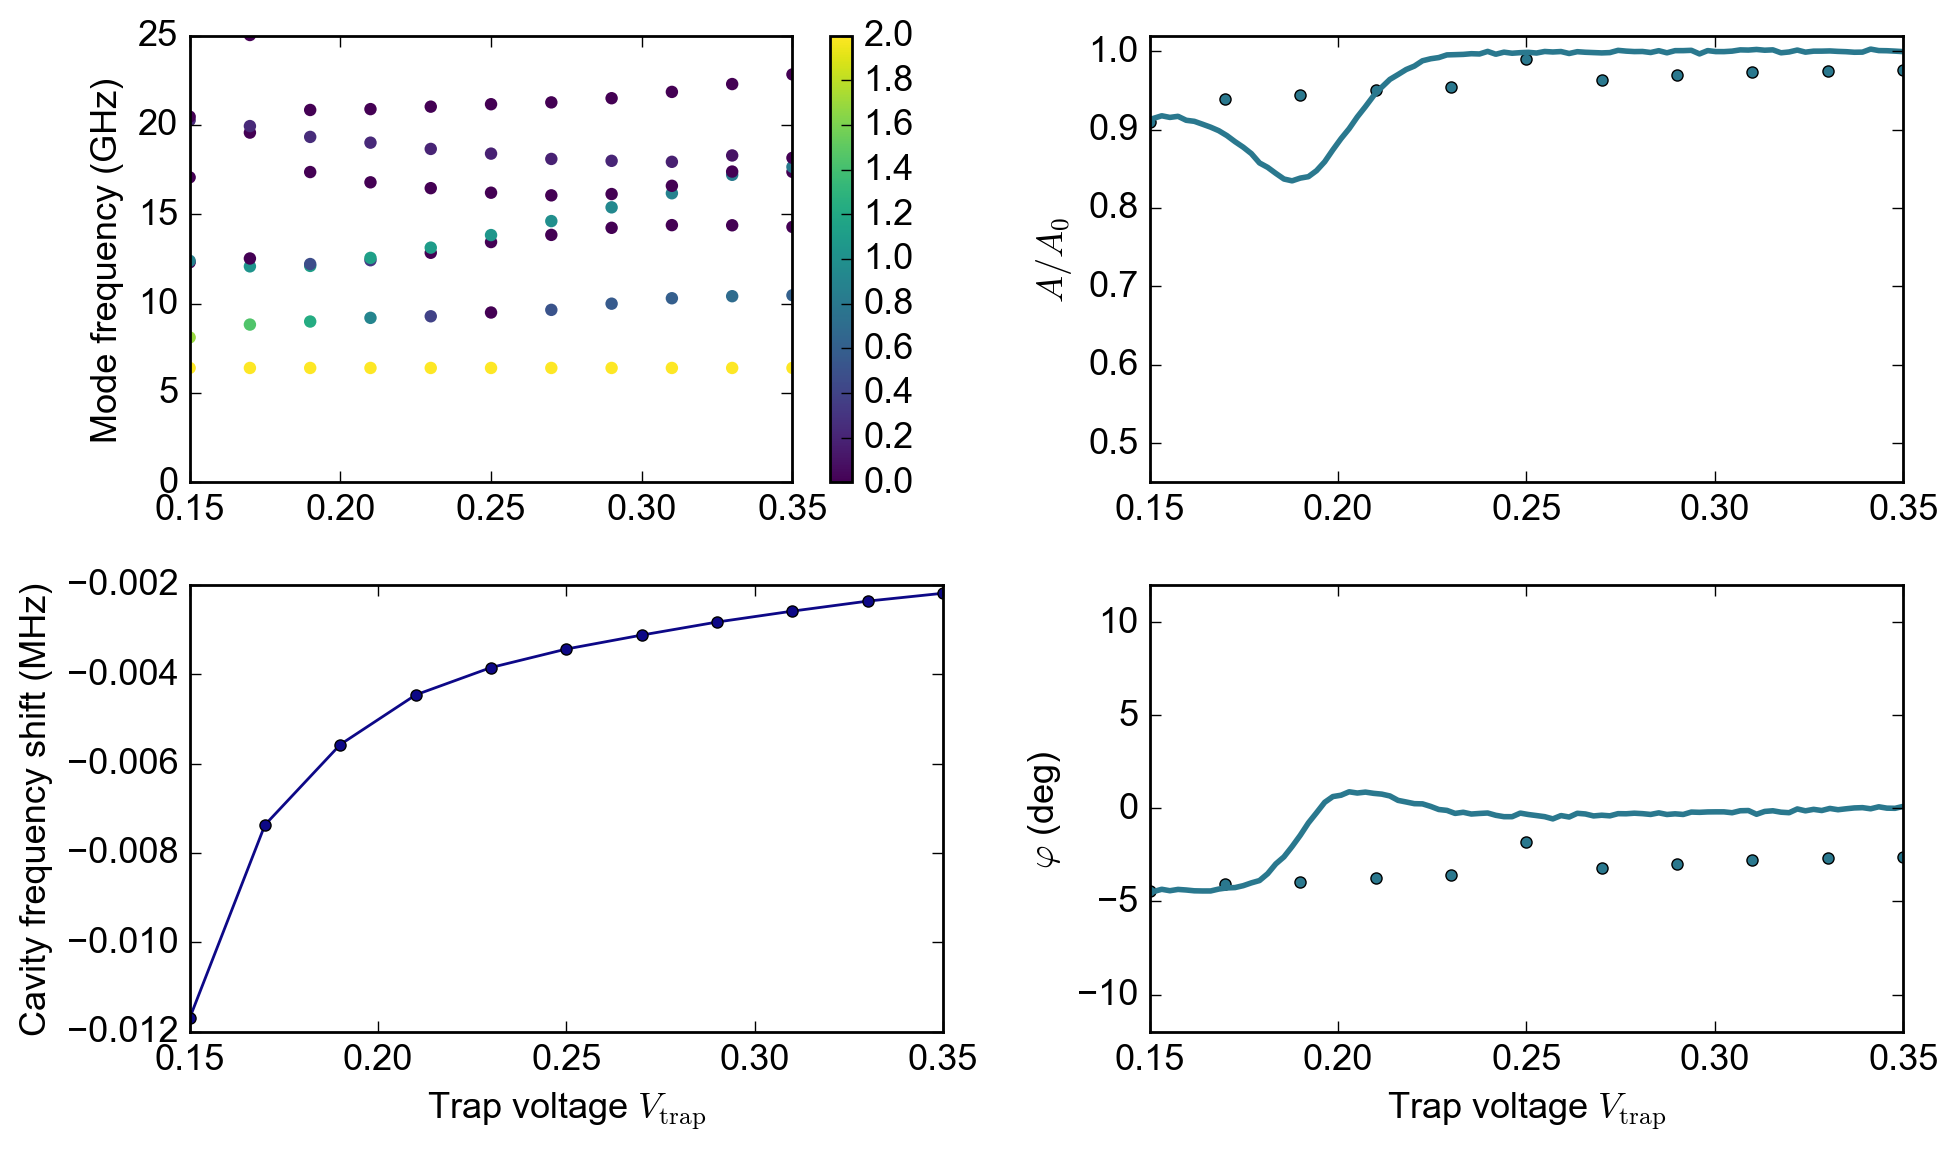

In [11]:
from TrapAnalysis import single_electron as se

# Choose here how many modes to consider in determining the susceptibility and the resonator response. 
# The numbers are not for a particular branch, but according to how strong each mode couples at each Vtrap
# 0: the cavity mode, DO NOT specify this number here.
# 1: the strongest coupled electron mode (note that the frequency of this mode may vary sharply with Vtrap)
# 2: the next strongest coupled electron mode, etc. 
# Example: [1, 2, 3] takes the first three strongest coupled modes at each Vtrap to calculate the suscpetibility.
electron_modes_to_consider = [1, 2] # Note: 0 is the cavity mode
kappa_tot = fs.resonator_constants['f0']/fs.resonator_constants['Q']
f_probe = fs.resonator_constants['f0']
f_cavity = fs.resonator_constants['f0']

fig = plt.figure(figsize=(10.,6.))
common.configure_axes(13)
plt.subplot(221)

# mag_signal, phase_signal = list(), list()
chi = np.zeros(len(couplings), dtype=np.complex128)
for i, g in enumerate(couplings):
    for mode in electron_modes_to_consider:
        chi[i] += se.susceptibility(6E6, f_probe, all_ordered_freqs[i, mode] * 1E9, 2 * 600E6)
        
    sc = plt.scatter([Vtrap[i]]*(2*N_e + 1), np.sqrt(EVals)[i, :] / (2 * np.pi * 1E9), 
                     c=np.log10(np.abs(EVecs[i, 0, :])), edgecolors='none', cmap=plt.cm.viridis,
                     vmin=0, vmax=2)
    
plt.colorbar(sc)

single_response = 2 * np.pi * (kappa_tot / 2.) / (2 * np.pi * (f_probe - f_cavity) - chi + 1j * 2 * np.pi * (kappa_tot / 2.))
mag_signal = 20 * np.log10(np.abs(single_response))
phase_signal = 180/np.pi * (np.arctan2(-np.imag(single_response), np.real(single_response)) - np.pi/2.)    
    
plt.xlim(min(Vtrap), max(Vtrap))
plt.ylabel("Mode frequency (GHz)")
plt.ylim(0, 25)

plt.subplot(223)
plt.plot(Vtrap, (all_ordered_freqs[:, 0] * 1E9 - fs.resonator_constants['f0'])/1E6, '-o', 
             color=common.rgb(0, 2*N_e+1) ,ms=4)
plt.xlim(min(Vtrap), max(Vtrap))
plt.xlabel("Trap voltage $V_\mathrm{trap}$")
plt.ylabel("Cavity frequency shift (MHz)")

plt.subplot(222)
plt.plot(Vtrap, 10 ** (mag_signal / 10.), 'o', color=color, ms=4, lw=.5)
plt.plot(Vtrap_experiment, vars()['mags_experiment_%d' % (N_e)], '-', lw=2, color=color)
# plt.ylabel("$S_{21}$ (dB)")
plt.ylabel("$A/A_0$")
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.ylim(0.45, 1.02)

plt.subplot(224)
plt.plot(Vtrap, phase_signal, 'o', color=color, ms=4)
plt.plot(Vtrap_experiment, vars()['phases_experiment_%d' % (N_e)], '-', lw=2, color=color)
plt.ylabel(r"$\varphi$ (deg)")
plt.xlabel("Trap voltage $V_\mathrm{trap}$")
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.ylim(-12, 12)

fig.tight_layout()

$\Delta f_0 = N_e g^2 / (\omega_e - \omega_0)$ so $g = \sqrt{(\omega_e - \omega_0)\Delta f_0 / N_e}$

In [54]:
print("g = ", 1E-6 * np.sqrt(5E9 * 2.4E3 / 2.), " MHz")

g =  2.44948974278  MHz


Finally, the plot above shows the simulated response of the cavity. There are multiple ways of doing this. The first one is shown in the lower left, which shows the cavity shift directly retrieved from the eigenvalue equation. **This does not include any decoherence but does consider all 2$N_e$ vibrational modes coupled to the resonator.** On the other hand, we can assume that the cavity is only strongly coupled to one of the modes (usually the one with the lowest frequency). In this case we can simulate **with decoherence, but only a single mode is coupled**. These results are shown on the right.

In [17]:
if 0:
    h5_filename = os.path.join(savepath, 'classical_mode_solver_%d_electrons.h5' % N_e )

    if os.path.exists(h5_filename):
        os.remove(h5_filename)

    print("%s ..."%h5_filename)
    myfile = dataCacheProxy(file_path=h5_filename)
    myfile.post("Vres", Vres)
    myfile.post("Vtrap", Vtrap)
    myfile.post("Vrg", Vrg)
    myfile.post("Vtg", Vtg)
    myfile.post("phases", phase_signal)
    myfile.post("mags", mag_signal)
    myfile.post("g", couplings)
    myfile.post("N_e", N_e)
    myfile.post("xi", tex)
    myfile.post("yi", tey)
    myfile.post("ordered_eigenfreqs", all_ordered_freqs)

It seems `linalg.eig` doesn't preserve the order of columns, but it _does_ preserve the rows. This means that the first row in `EVecs` contains the cavity contributions and that the next rows are labeled from $x_1$ through $x_N$ and then $y_1$ through $y_N$, where $N$ is the number of electrons.

In `largest_cavity_contribitions` the first index contains the column number of `EVecs` that is related to the cavity mode. To be more explicit `cavity_eigenmode = EVecs[:, cavity_contributions[0]]`. We can also look at it's eigenvalue, or frequency and confirm that it is close to the value we gave it:

In [25]:
# Find the index for which the strongest coupled electron mode crosses the resonator.
# idx = common.find_nearest(all_ordered_freqs[:, 1], fs.resonator_constants['f0']) 
# Or if you'd rather just specify the voltage at which you want to visualize the electron mode, run the code below
idx = common.find_nearest(Vtrap, 0.210)

cf = all_ordered_freqs[idx, 0]
ef = all_ordered_freqs[idx, 1]
g = 5E6

print("Cavity shift is %.0f kHz" % ((cf - fs.resonator_constants['f0']/1E9)*1E6))
print("Dispersive shift from strongest mode should be %.0f kHz" \
      % -(g**2/(ef - fs.resonator_constants['f0']) * 1E-3))

Cavity shift is -4 kHz
Dispersive shift from strongest mode should be 4 kHz


In [12]:
fs.set_dc_interpolator(Vres[idx], Vtrap[idx], Vrg[idx], Vtg[idx])

print("About to visualize the electron orbitals at Vtrap = %.3f V" % (Vtrap[idx]))
xeval = np.linspace(-3, 3, 251)
yeval = np.linspace(-4, 4, 101)
xinterp, yinterp = np.meshgrid(xeval, yeval)

VisualizePotential = np.zeros((len(yeval), len(xeval)))
for k in range(len(yeval)):
    VisualizePotential[k, :] = fs.dc_interpolator(xinterp[k, :] * 1E-6, yinterp[k, 0] * 1E-6).flatten()

About to visualize the electron orbitals at Vtrap = 0.350 V


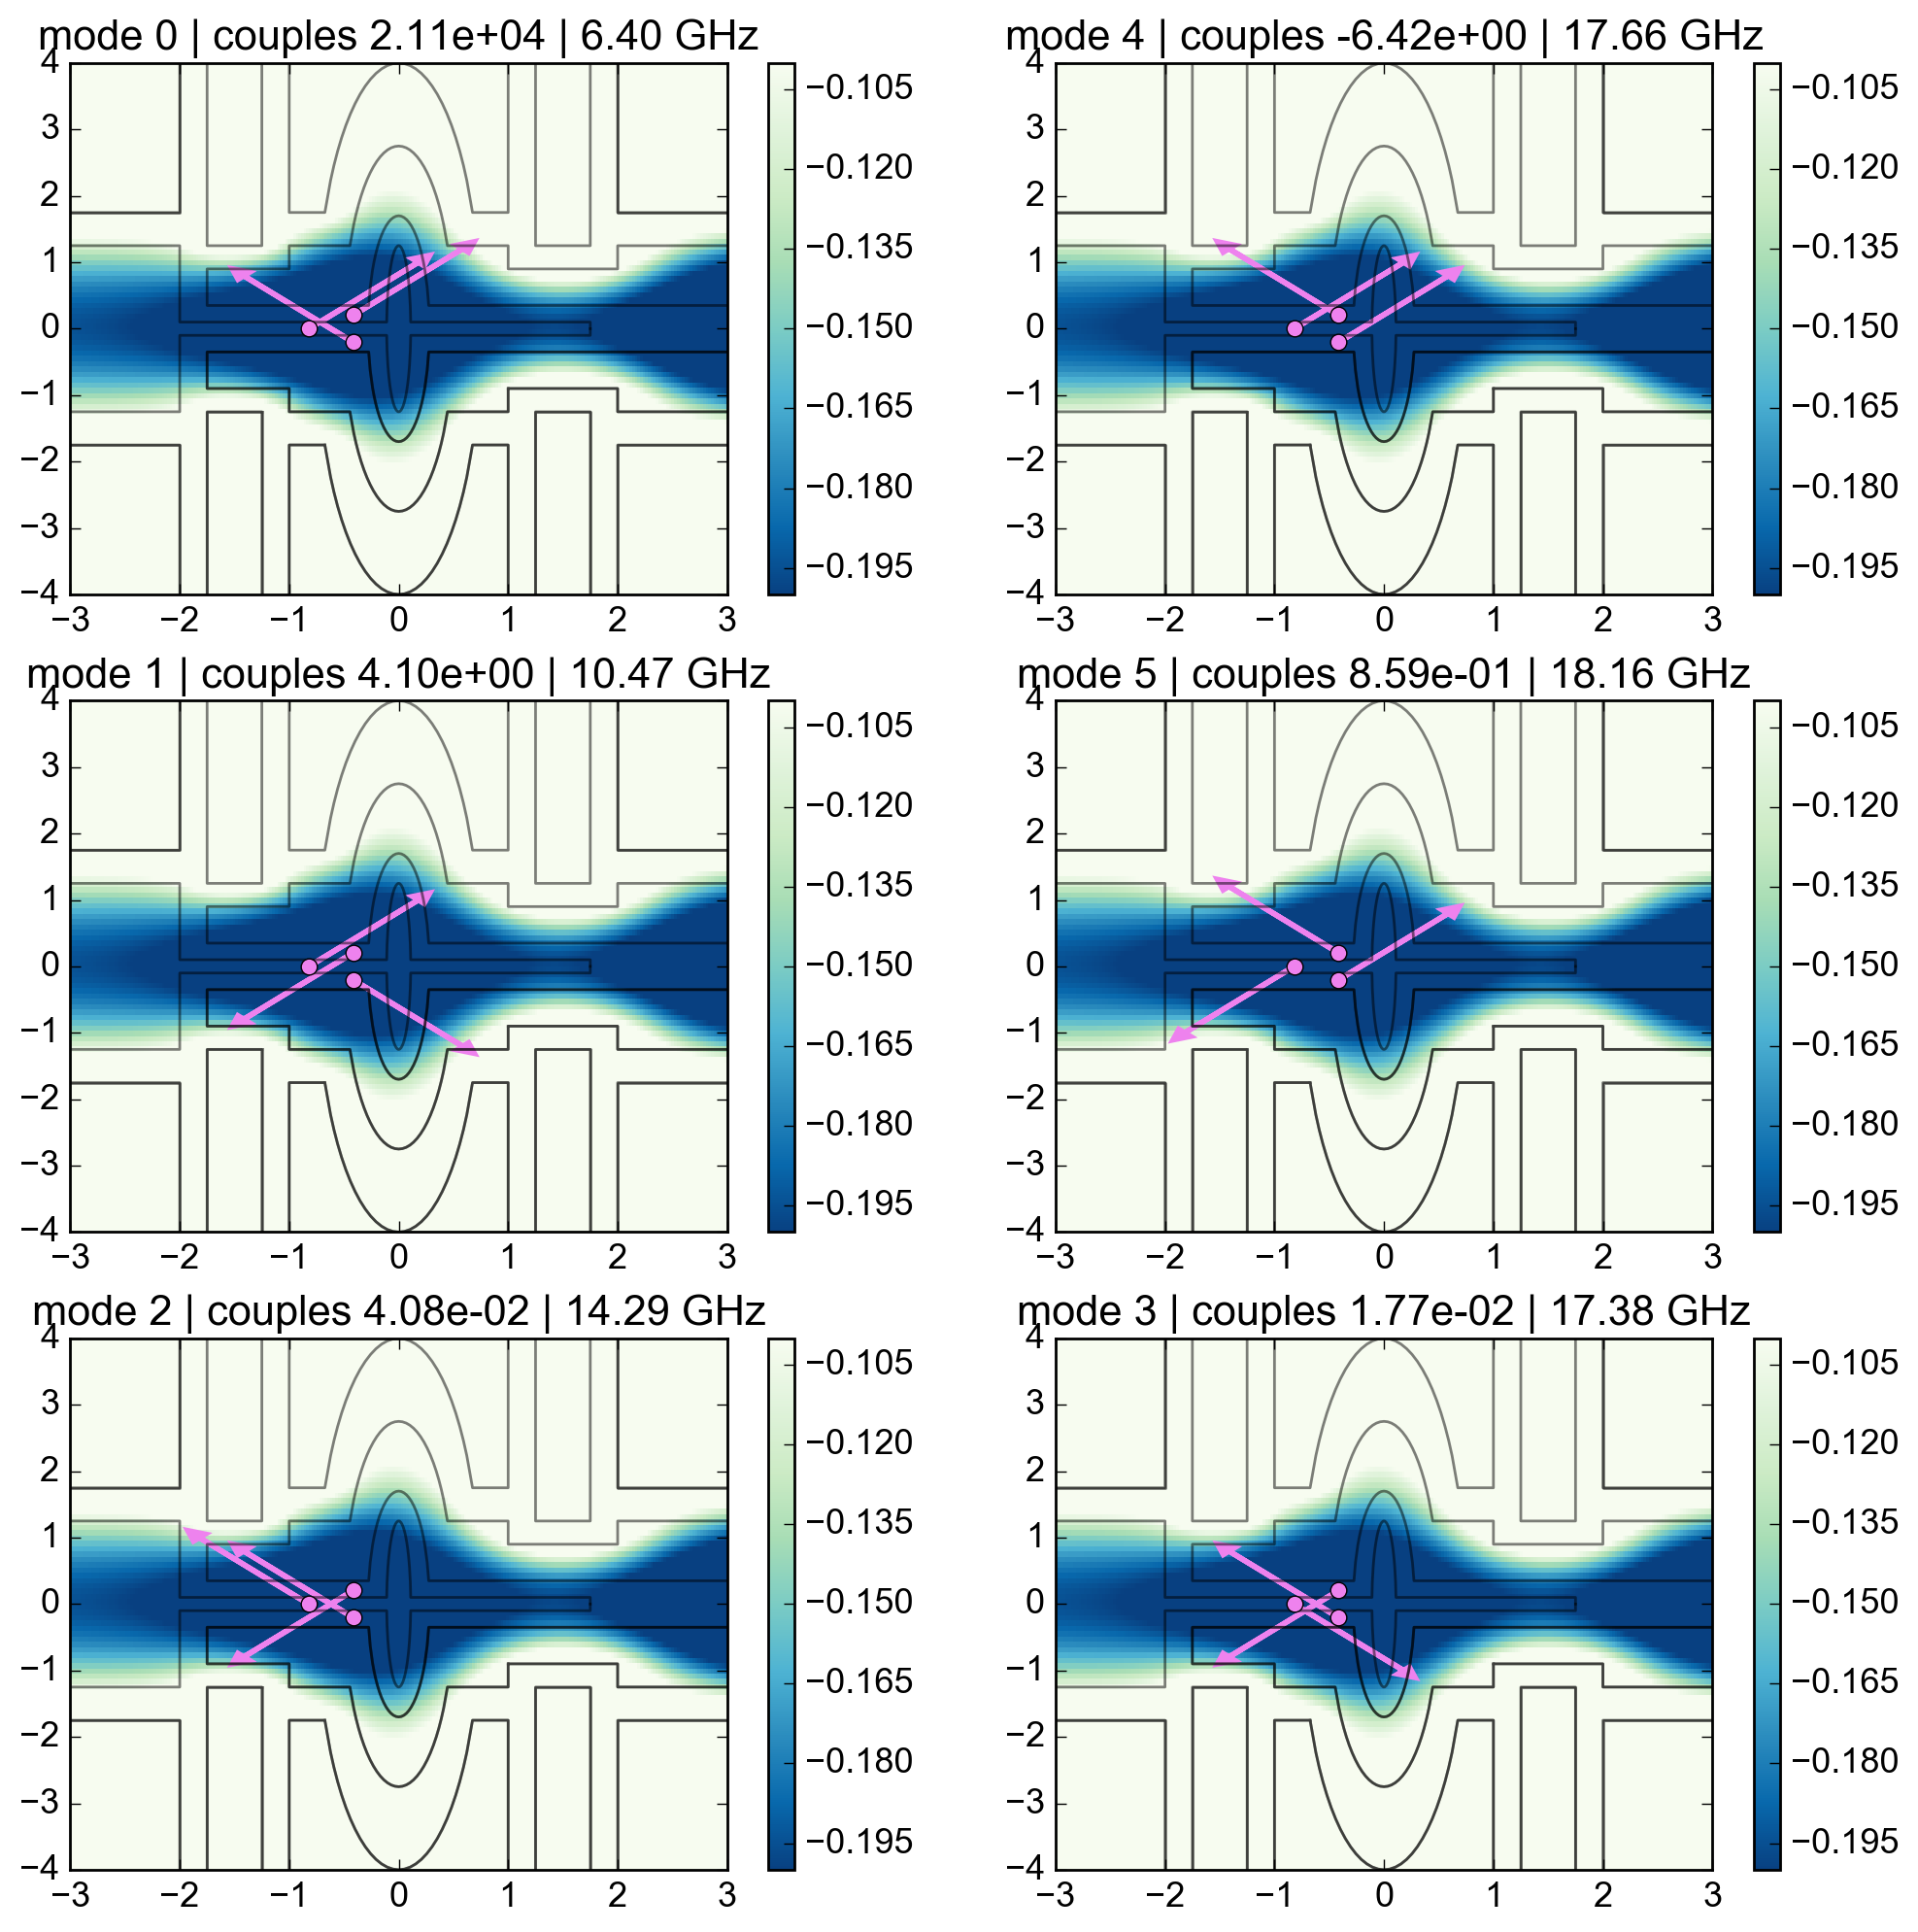

In [13]:
plt.figure(figsize=(2*6., 3*4.))

for k in range(min([2*N_e + 1, 6])):
    cavity_contributions = EVecs[idx, 0, :]
    largest_cavity_contributions = np.argsort(np.abs(cavity_contributions))[::-1]
    mode_nr = largest_cavity_contributions[k]
    amp = EVecs[idx, 1:, mode_nr] / np.abs(EVecs[idx, 1:, mode_nr])
    plt.subplot(3, 2, k+1)
#     plt.pcolormesh(xinterp, yinterp, fs.Ey(xinterp * 1E-6, yinterp * 1E-6), 
#                    cmap=plt.cm.RdBu, vmin=-2E5 , vmax=2E5)
    plt.pcolormesh(xinterp, yinterp, VisualizePotential, cmap=plt.cm.GnBu_r, vmin=-0.2, vmax=-0.1)
    anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                     color="k", alpha=0.5)
    #plt.plot(tex[idx, :] * 1E6, tey[idx, :] * 1E6, 'o', color='violet', alpha=1.0)
    plt.plot(el_x[idx, :] * 1E6, el_y[idx, :] * 1E6, 'o', color='violet', alpha=1.0)
    for m in range(N_e):
        plt.arrow(x=el_x[idx, m] * 1E6, y=el_y[idx, m] * 1E6, dx=amp[m], 
                  dy=amp[N_e+m] * 1, head_width=0.15, head_length=0.15, fc='violet', ec='violet', lw=2)
    plt.title("mode %d | couples %.2e | %.2f GHz" % (mode_nr, EVecs[idx, 0, mode_nr], 
                                                     np.sqrt(EVals[idx, mode_nr])/(2*np.pi*1E9)))
    plt.xlim(min(xeval), max(xeval))
    plt.ylim(min(yeval), max(yeval))
    plt.colorbar()

# Check the data

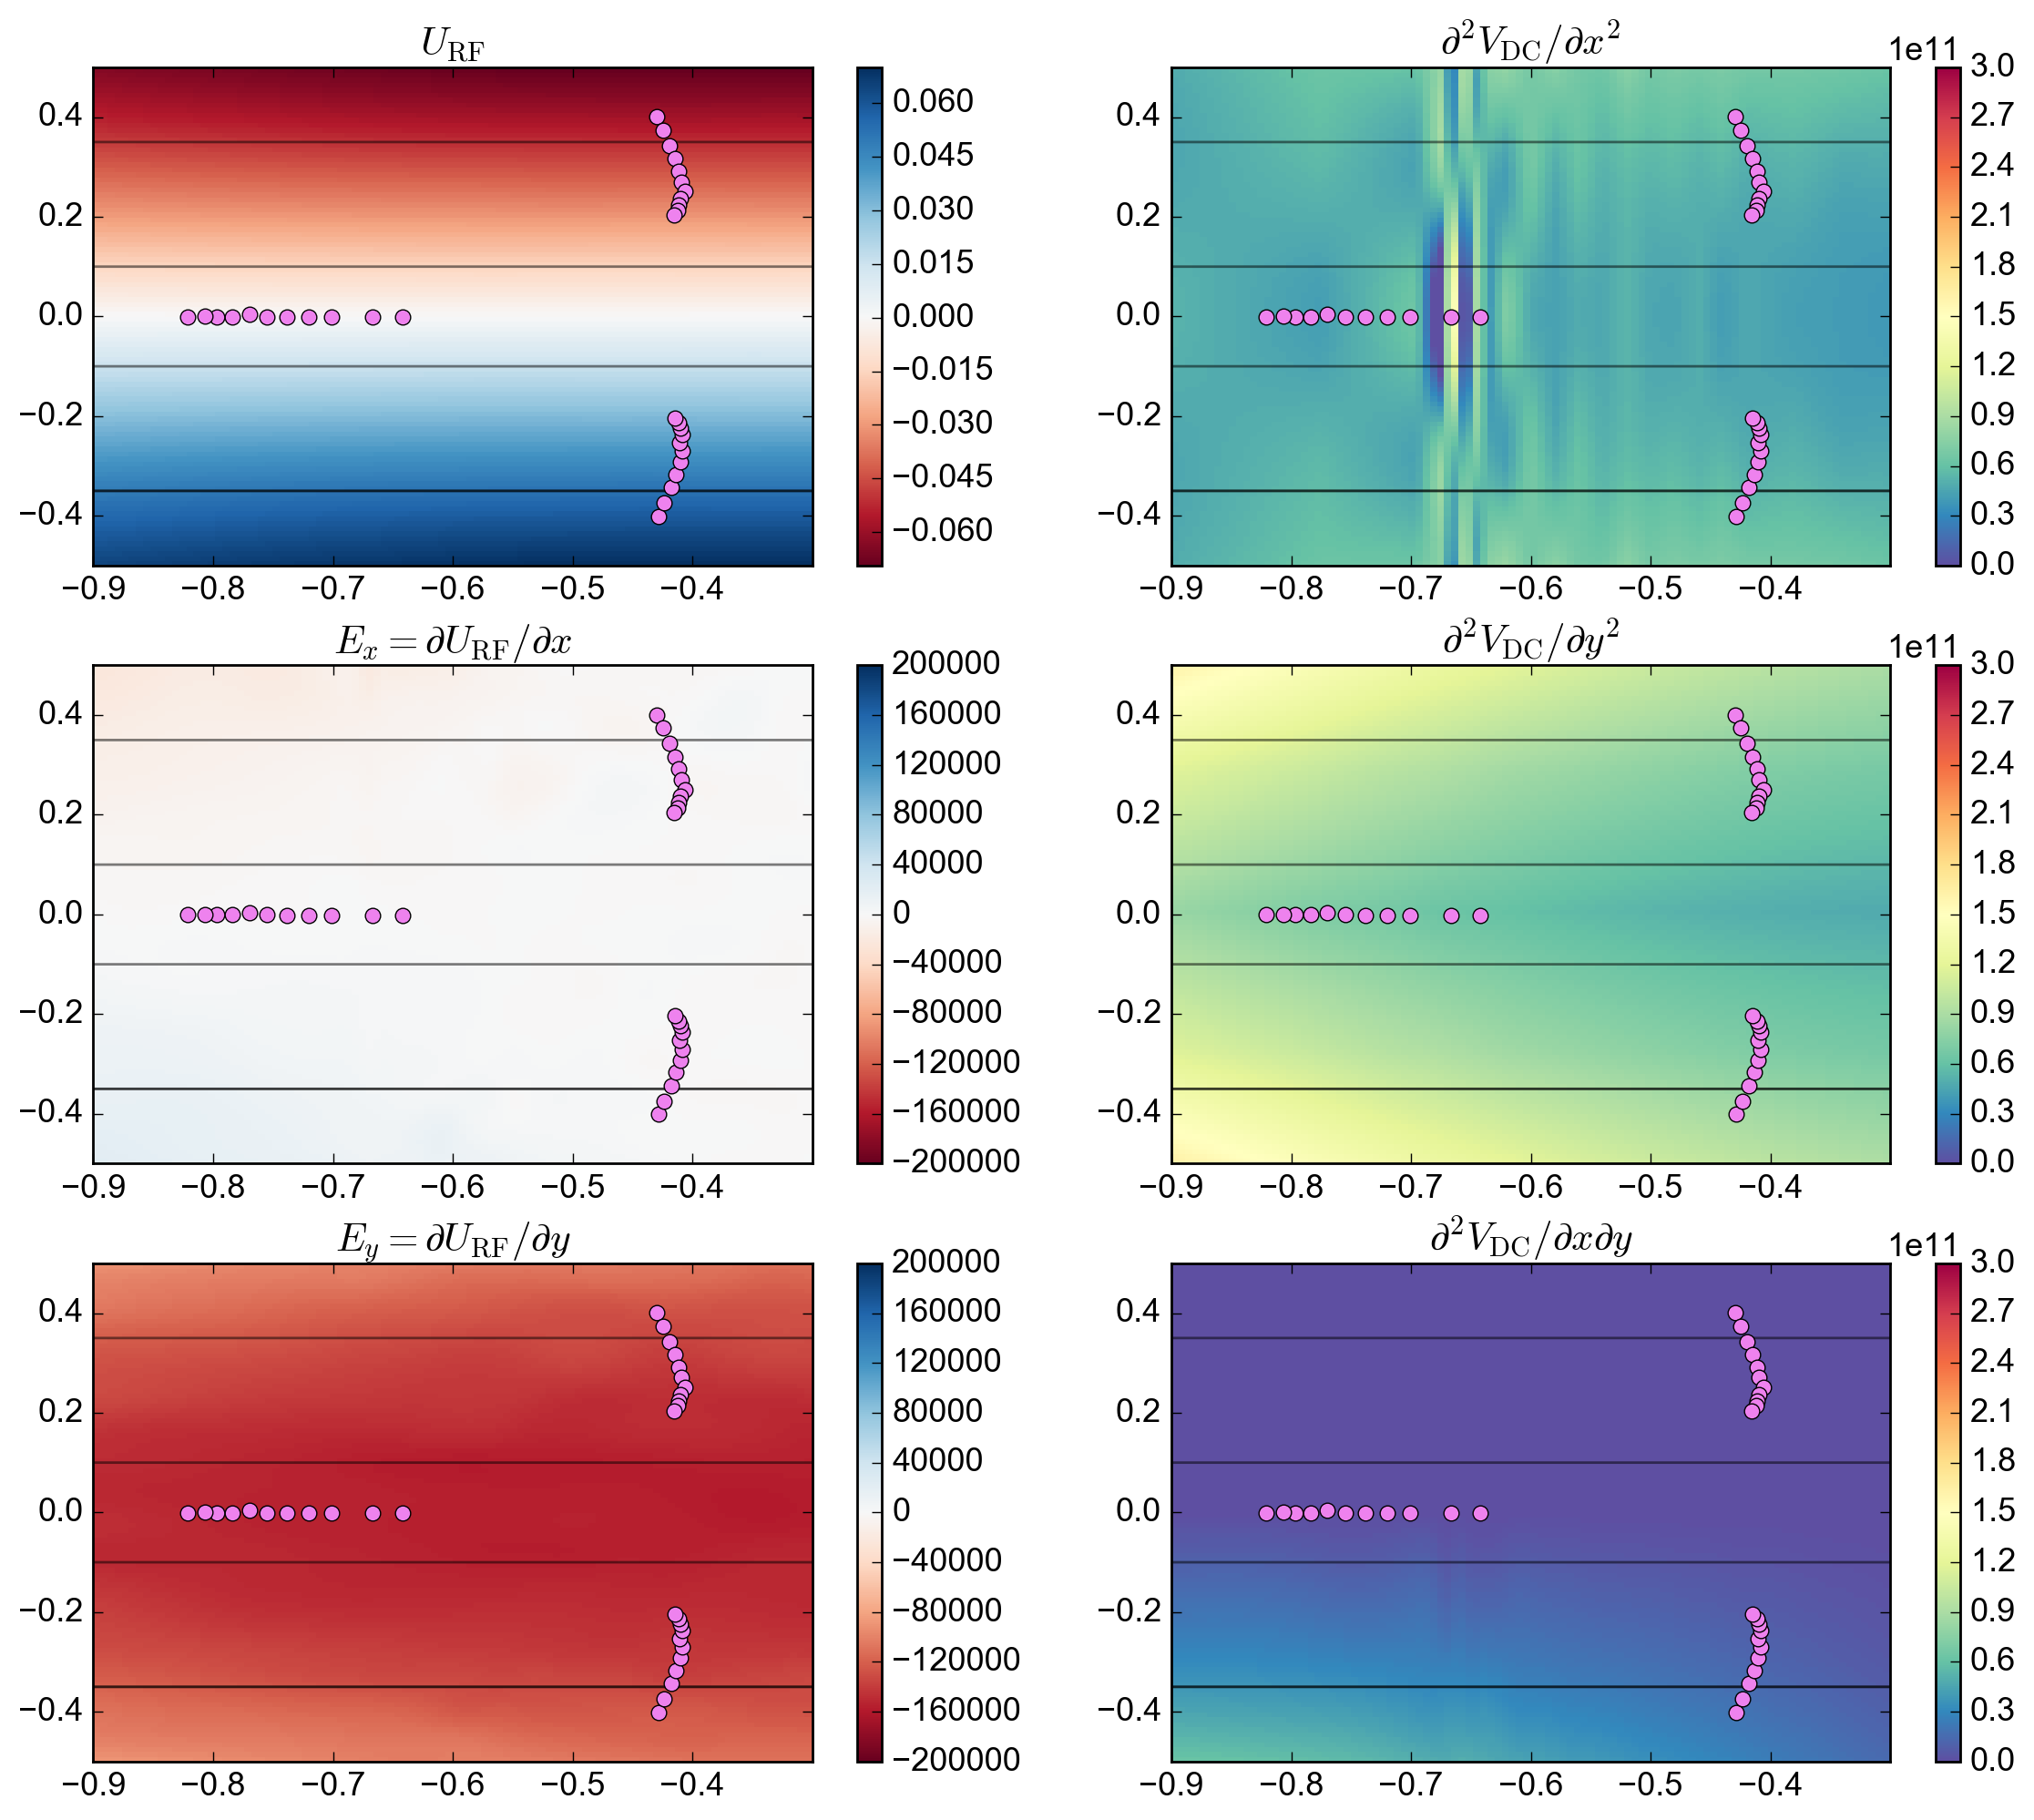

In [14]:
xeval = np.linspace(-0.9, -0.3, 101)
yeval = np.linspace(-0.5, 0.5, 101)
xinterp, yinterp = np.meshgrid(xeval, yeval)

fig = plt.figure(figsize=(2*7.,3*4.))
plt.subplot(321)
plt.pcolormesh(xinterp, yinterp, fs.rf_interpolator.ev(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.RdBu)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(el_x * 1E6, el_y * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$U_\mathrm{RF}$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

plt.subplot(323)
plt.pcolormesh(xinterp, yinterp, fs.Ex(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.RdBu, vmin=-2E5, vmax=2E5)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(el_x * 1E6, el_y * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$E_x = \partial U_\mathrm{RF}/\partial x$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

plt.subplot(325)
plt.pcolormesh(xinterp, yinterp, fs.Ey(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.RdBu, vmin=-2E5, vmax=2E5)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(el_x * 1E6, el_y * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$E_y = \partial U_\mathrm{RF}/\partial y$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

plt.subplot(322)
plt.pcolormesh(xinterp, yinterp, fs.curv_xx(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.Spectral_r, vmin=0, vmax=3E11)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(el_x * 1E6, el_y * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$\partial^2 V_\mathrm{DC}/\partial x^2$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

plt.subplot(324)
plt.pcolormesh(xinterp, yinterp, fs.curv_yy(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.Spectral_r, vmin=0, vmax=3E11)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(el_x * 1E6, el_y * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$\partial^2 V_\mathrm{DC}/\partial y^2$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

plt.subplot(326)
plt.pcolormesh(xinterp, yinterp, fs.curv_xy(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.Spectral_r, vmin=0, vmax=3E11)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(el_x * 1E6, el_y * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$\partial^2 V_\mathrm{DC}/\partial x \partial y$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

fig.tight_layout()

# Retrieve data from different $N_e$ in a single plot

classical_mode_solver_1_electrons.h5
classical_mode_solver_2_electrons.h5
classical_mode_solver_3_electrons.h5
classical_mode_solver_4_electrons.h5


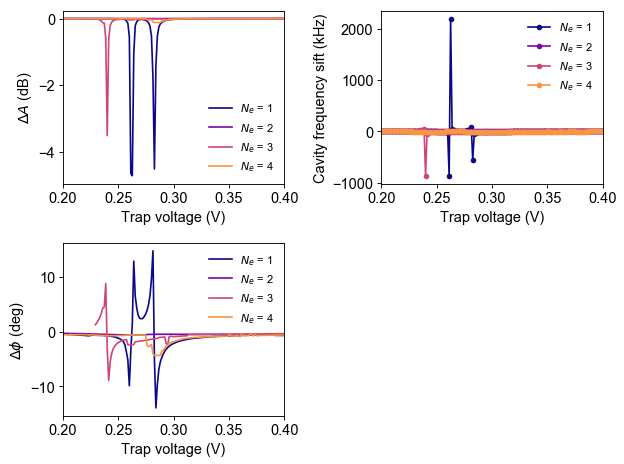

In [123]:
fns = glob(os.path.join(savepath, "*.h5"))

fig = plt.figure(figsize=(8.,6.))
common.configure_axes(13)

for kk, fn in enumerate(fns):
    print(os.path.split(fn)[1])
    thisfile = dataCacheProxy(file_path=fn)
    
    Vtrap = thisfile.get('Vtrap')[0]
    all_ordered_freqs = thisfile.get('ordered_eigenfreqs')[0]
    N_e = thisfile.get("N_e")[0]
    mag_signal = thisfile.get("mags")[0]
    phase_signal = thisfile.get("phases")[0]
    
    plt.subplot(222)
    plt.plot(Vtrap, (all_ordered_freqs[:, 0] * 1E9 - 6.405E9)/1E3, '-o', 
                 color=common.rgb(kk, len(fns)) ,ms=4, label='$N_e$ = %d'%N_e)
    plt.xlim(min(Vtrap), max(Vtrap))
    plt.xlabel("Trap voltage (V)")
    plt.ylabel("Cavity frequency sift (kHz)")
    plt.legend(loc=0, prop={"size" : 10}, frameon=False)

    plt.subplot(221)
    plt.plot(Vtrap, mag_signal, color=common.rgb(kk, len(fns)), label='$N_e$ = %d'%N_e)
    plt.xlim(min(Vtrap), max(Vtrap))
    plt.xlabel("Trap voltage (V)")
    plt.ylabel("$\Delta A$ (dB)")
    plt.legend(loc=0, prop={"size" : 10}, frameon=False)
    
    plt.subplot(223)
    plt.plot(Vtrap, phase_signal, color=common.rgb(kk, len(fns)), label='$N_e$ = %d'%N_e)
    plt.xlim(min(Vtrap), max(Vtrap))
    plt.xlabel("Trap voltage (V)")
    plt.ylabel("$\Delta \phi$ (deg)")
    plt.legend(loc=0, prop={"size" : 10}, frameon=False)
    
fig.tight_layout()

# Approximation of $\partial ^2 V_\mathrm{DC} / \partial y^2$ with fitting

In [ ]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8.,3.))
common.configure_axes(13)

cols = [plt.cm.viridis(g) for g in np.linspace(0, 1, N_e)]
kk = 0

for xe, ye in zip(tex[inspect_idx, :], tey[inspect_idx, :]):
    print(xe, ye)
    plt.subplot(121)
    
    ydata = fs.dc_interpolator(xe, yev*1E-6).flatten().astype(np.float64)
    xdata = yev.astype(np.float64)
    fitspan = 0.025
    
    print("Electron #%d: curvature in x : " % (kk+1), 
          fs.curv_yy(np.array(xe), np.array(ye)) / 1E12, "eV/%sm^2"%(chr(956)))
    
    # Fit function: y = a0 + a1 * x + a2 * x ** 2 
    fr, ferr = kfit.fit_poly(xdata, ydata, fitparams=[np.min(ydata), 0.0, 0.01], 
                             domain=(ye*1E6-fitspan/2., ye*1E6+fitspan/2.), 
                             verbose=False, showfit=False)
    print("While fit gives: ", 2 * fr[2])
    
    # Fit function: y = a0 + a1 * x ** 2 + a2 * x ** 4
#     fr, ferr = kfit.fit_poly(xdata, ydata, fitparams=[np.min(ydata), 0, 0], mode='even', 
#                              domain=(ye*1E6-fitspan/2., ye*1E6+fitspan/2.), 
#                              verbose=False, showfit=False)
#     print("While fit gives: ", 2 * fr[1] + 12 * fr[2] * xe ** 2)
    
    plt.plot(xdata, kfit.polyfunc(xdata, *fr), '-k')
    plt.plot(xdata, ydata, '-', color=cols[kk])
    plt.plot(ye * 1E6, fs.dc_interpolator(xe, ye), 'o', color=cols[kk])
    
    plt.subplot(122)
    plt.plot(yev, fs.curv_yy(xe * np.ones(len(yev)), yev * 1E-6) / 1E12, color=cols[kk])
    plt.plot(ye * 1E6, fs.curv_yy(xe, ye) / 1E12, 'o', color=cols[kk])
        
    for sliding_y in xdata[::10]:
        fr, ferr = kfit.fit_poly(xdata, ydata.flatten(), fitparams=[-0.2, 1, 0.01], 
                                 domain=(sliding_y-fitspan/2., sliding_y+fitspan/2.), 
                                 verbose=False, showfit=False)

        plt.plot(sliding_y, 2*fr[2], '.k', ms=2)
        
#         fr, ferr = kfit.fit_poly(xdata, ydata, fitparams=[np.min(ydata), 0, 0], mode='even',
#                                  domain=(sliding_y-fitspan/2., sliding_y+fitspan/2.),
#                                  verbose=False, showfit=False)
#         plt.plot(sliding_y, 2 * fr[1] + 12 * fr[2] * xe ** 2, '.k', ms=2)
    
    kk += 1
    
fig.tight_layout()